In [4]:
!pip install seqeval -q 

In [ ]:
!pip install evaluate

In [7]:
from datasets import load_dataset
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import evaluate
import wandb
from collections import Counter
from transformers import AutoTokenizer
from transformers import DataCollatorForTokenClassification
from datasets import load_metric  
from transformers import AutoModelForTokenClassification
from transformers import TrainingArguments
from transformers import Trainer

# Data Visualization - CONLL-2003

In [ ]:
dataset = load_dataset('conll2003')
dataset

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


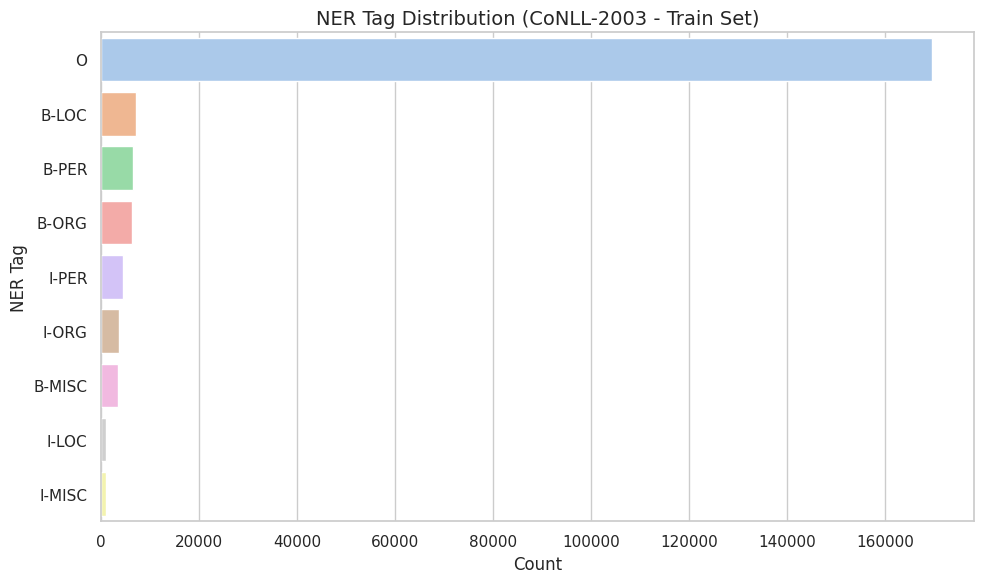

In [4]:
def get_tag_distribution(dataset_split, label_list):
    all_tags = [tag for example in dataset_split["ner_tags"] if example for tag in example]
    tag_counts = pd.Series(all_tags).value_counts().sort_values(ascending=False)
    tag_counts.index = tag_counts.index.astype(int)
    tag_counts.index = [label_list[i] for i in tag_counts.index]
    return tag_counts

labels = dataset["train"].features["ner_tags"].feature.names
tag_counts = get_tag_distribution(dataset["train"], labels)

plt.figure(figsize=(10, 6))
sns.set_theme(style="whitegrid")
sns.barplot(x=tag_counts.values, y=tag_counts.index, palette="pastel")
plt.title("NER Tag Distribution (CoNLL-2003 - Train Set)", fontsize=14)
plt.xlabel("Count", fontsize=12)
plt.ylabel("NER Tag", fontsize=12)
plt.tight_layout()
plt.show()


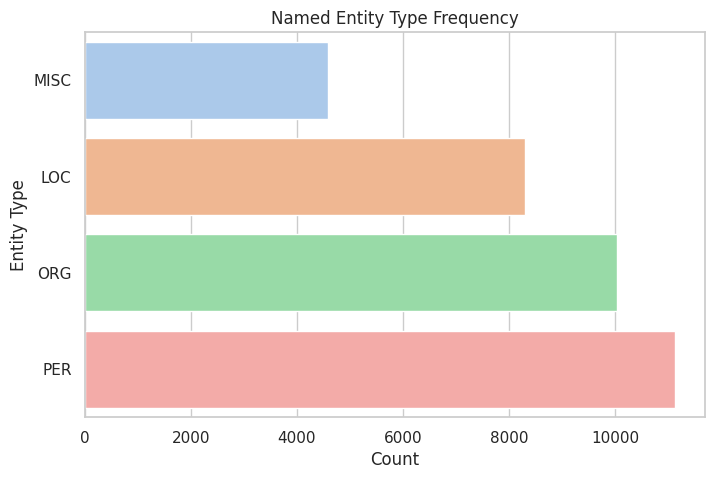

In [5]:
def get_entity_counts(dataset_split, labels):
    counter = Counter()
    for example in dataset_split:
        for tag in example["ner_tags"]:
            label = labels[tag]
            if label != "O":
                entity_type = label.split("-")[-1]
                counter[entity_type] += 1
    return counter

entity_counter = get_entity_counts(dataset["train"], labels)
entity_df = pd.DataFrame.from_dict(entity_counter, orient="index", columns=["count"]).sort_values("count")

plt.figure(figsize=(8, 5))
sns.barplot(x=entity_df["count"], y=entity_df.index, palette="pastel")
plt.title("Named Entity Type Frequency")
plt.xlabel("Count")
plt.ylabel("Entity Type")
plt.show()

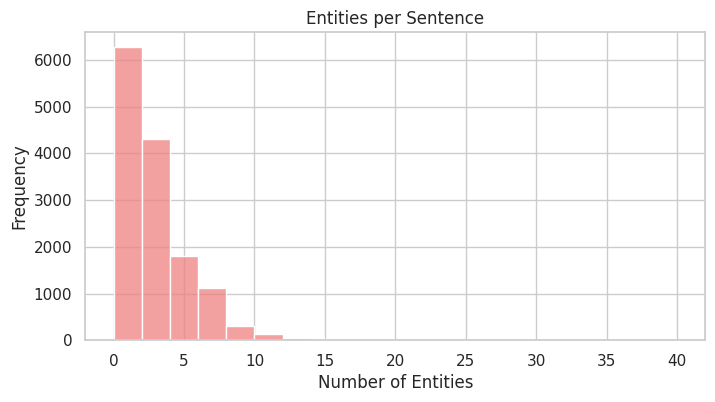

In [6]:
entity_counts = [
    sum(1 for tag in ex["ner_tags"] if labels[tag] != "O") 
    for ex in dataset["train"]
]

plt.figure(figsize=(8, 4))
sns.histplot(entity_counts, bins=20, kde=False, color="lightcoral")
plt.title("Entities per Sentence")
plt.xlabel("Number of Entities")
plt.ylabel("Frequency")
plt.show()


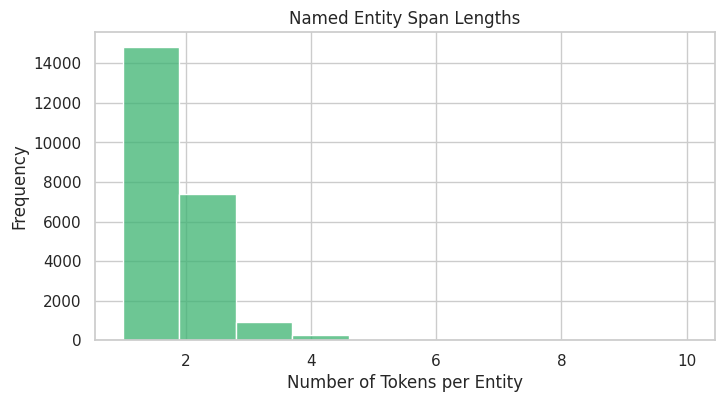

In [7]:
def entity_lengths(dataset_split, labels):
    lengths = []
    current_length = 0
    for example in dataset_split:
        for tag in example["ner_tags"]:
            label = labels[tag]
            if label.startswith("B-"):
                if current_length > 0:
                    lengths.append(current_length)
                current_length = 1
            elif label.startswith("I-"):
                current_length += 1
            else:
                if current_length > 0:
                    lengths.append(current_length)
                    current_length = 0
        if current_length > 0:
            lengths.append(current_length)
            current_length = 0
    return lengths

lengths = entity_lengths(dataset["train"], labels)

plt.figure(figsize=(8, 4))
sns.histplot(lengths, bins=10, color="mediumseagreen")
plt.title("Named Entity Span Lengths")
plt.xlabel("Number of Tokens per Entity")
plt.ylabel("Frequency")
plt.show()


# Data Preparation

In [12]:
def align_target(labels, word_ids):
    begin2inside = {1: 2, 3: 4,5: 6, 7: 8}
    align_labels = []
    last_word = None
    for word in word_ids:
        if word is None:
            label = -100 
        elif word != last_word:
            label = labels[word]
        else:
            label = labels[word]
            if label in begin2inside:
                label = begin2inside[label]
        align_labels.append(label)
        last_word = word
    return align_labels
    
def tokenize_fn(batch):
    tokenized_inputs = tokenizer(batch['tokens'], truncation=True, is_split_into_words=True)
    labels_batch = batch['ner_tags']
    aligned_targets_batch = []
    for i, labels in enumerate(labels_batch):
        word_ids = tokenized_inputs.word_ids(i)
        aligned_targets_batch.append(align_target(labels, word_ids))
    tokenized_inputs["labels"] = aligned_targets_batch
    return tokenized_inputs

def compute_metrics(logits_and_labels):
  logits, labels = logits_and_labels 
  predictions = np.argmax(logits, axis=-1)
  str_labels = [[label_names[t] for t in label if t!=-100] for label in labels]
  str_preds = [[label_names[p] for (p, t) in zip(prediction, label) if t != -100]
    for prediction, label in zip(predictions, labels)]
  results = metric.compute(predictions=str_preds, references=str_labels)
  return {
    "precision": results["overall_precision"],
    "recall": results["overall_recall"], 
    "f1": results["overall_f1"],
    "accuracy": results["overall_accuracy"]  
  }

# DistilBert

In [41]:
checkpoint = 'distilbert-base-cased'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
tokenized_dataset = dataset.map(tokenize_fn, batched=True, remove_columns=dataset['train'].column_names)
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)
batch = data_collator([tokenized_dataset['train'][i] for i in range(2)])
metric = load_metric("seqeval")

  0%|          | 0/15 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


## Create Model 

In [50]:
label_names = dataset['train'].features['ner_tags'].feature.names
id2label = {k: v for k, v in enumerate(label_names)} 
label2id = {v: k for k, v in enumerate(label_names)}

model = AutoModelForTokenClassification.from_pretrained(
  checkpoint,
  id2label=id2label,  
  label2id=label2id
)

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
model

DistilBertForTokenClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
    

In [52]:
training_args = TrainingArguments(
  output_dir = "ner-bert-conll2003",
  evaluation_strategy = "epoch",
  logging_strategy="epoch", 
  report_to="wandb",
  run_name="ner-distilbert-run-1",
  learning_rate = 2e-5, 
  per_device_train_batch_size = 16,
  per_device_eval_batch_size = 16,
  num_train_epochs = 5,
  weight_decay = 0.01
)

trainer = Trainer(
  model=model, 
  args=training_args,
  train_dataset=tokenized_dataset["train"],
  eval_dataset=tokenized_dataset["validation"],
  tokenizer=tokenizer,
  compute_metrics=compute_metrics,
  data_collator=data_collator
)

trainer.train()
trainer.save_model('fine_tuned_distilbert')

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.186300,0.081016,0.873888,0.909626,0.891399,0.976247
2,0.059200,0.068195,0.891494,0.927802,0.909286,0.980897
3,0.032100,0.068299,0.910147,0.935880,0.922834,0.982825
4,0.020200,0.068057,0.915929,0.940592,0.928097,0.984253
5,0.013900,0.070550,0.916708,0.939078,0.927758,0.984194


## Evaluation

In [55]:
eval_results = trainer.evaluate()
wandb.log(eval_results)

In [56]:
eval_results

{'eval_loss': 0.07055032253265381,
 'eval_precision': 0.9167077378018729,
 'eval_recall': 0.9390777515987883,
 'eval_f1': 0.9277579183639537,
 'eval_accuracy': 0.9841937952551951,
 'eval_runtime': 4.9142,
 'eval_samples_per_second': 661.556,
 'eval_steps_per_second': 41.513,
 'epoch': 5.0}

In [31]:
predictions_output = trainer.predict(tokenized_dataset["validation"])
preds = predictions_output.predictions
labels = predictions_output.label_ids

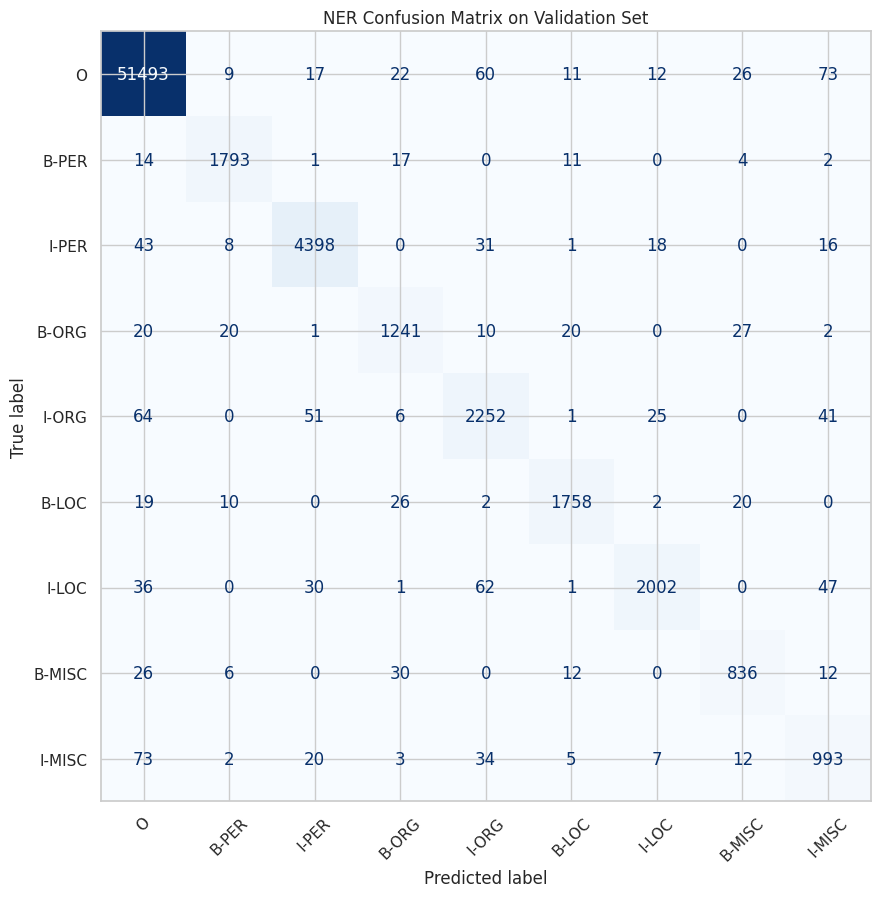

In [32]:
predicted_labels = np.argmax(preds, axis=-1)

true_tags = []
pred_tags = []

for true, pred in zip(labels, predicted_labels):
    for t, p in zip(true, pred):
        if t != -100:
            true_tags.append(label_names[t])
            pred_tags.append(label_names[p])
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(true_tags, pred_tags, labels=label_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45, colorbar=False)
plt.title("NER Confusion Matrix on Validation Set")
plt.show()


In [42]:
predictions_output = trainer.predict(tokenized_dataset["validation"])
logits = predictions_output.predictions
true_labels = predictions_output.label_ids

pred_indices = np.argmax(logits, axis=-1)
pred_tags = []
true_tags = []

for preds, labels in zip(pred_indices, true_labels):
    pred_seq = []
    true_seq = []
    for p, l in zip(preds, labels):
        if l != -100:
            pred_seq.append(label_names[p])
            true_seq.append(label_names[l])
    pred_tags.append(pred_seq)
    true_tags.append(true_seq)


results = metric.compute(predictions=pred_tags, references=true_tags)

In [44]:
import pandas as pd

def print_results_table(results):
    overall_data = {
        k: [round(v, 4)] for k, v in results.items() if isinstance(v, float)
    }
    overall_df = pd.DataFrame(overall_data)
    print("Overall Metrics:")
    print(overall_df.to_string(index=False))

    per_entity_rows = []

    for entity, scores in results.items():
        if isinstance(scores, dict):
            row = {"Entity": entity}
            for metric_name, value in scores.items():
                row[metric_name.capitalize()] = round(value, 4)
            per_entity_rows.append(row)

    entity_df = pd.DataFrame(per_entity_rows)
    entity_df = entity_df.set_index("Entity")
    
    print("\nPer-Entity Metrics:")
    print(entity_df.to_string())

print_results_table(results)


Overall Metrics:
 overall_precision  overall_recall  overall_f1  overall_accuracy
            0.9087          0.9327      0.9205            0.9826

Per-Entity Metrics:
        Precision  Recall      F1  Number
Entity                                   
LOC        0.9475  0.9521  0.9498    1837
MISC       0.8153  0.8666  0.8402     922
ORG        0.8744  0.9083  0.8910    1341
PER        0.9447  0.9642  0.9543    1842


In [48]:
from huggingface_hub import notebook_login
notebook_login()

model_repo_name = "ner-bert-conll2003"
hf_username = ""
trainer.push_to_hub(model_repo_name)

training_args.bin:   0%|          | 0.00/4.03k [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model.bin:   0%|          | 0.00/261M [00:00<?, ?B/s]

'https://huggingface.co/nanigock/fine_tuned_model/tree/main/'

# Bert-base-cased


In [ ]:
from datasets import load_metric
from transformers import (
    AutoTokenizer, AutoModelForTokenClassification,
    DataCollatorForTokenClassification, TrainingArguments, Trainer
)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# === Constants ===
checkpoint = 'bert-base-cased'
output_dir = "ner-bert-conll2003"

# === Load Tokenizer, Model, Data ===
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
label_names = dataset['train'].features['ner_tags'].feature.names
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {label: i for i, label in enumerate(label_names)}

# === Tokenize Dataset ===
tokenized_dataset = dataset.map(tokenize_fn, batched=True, remove_columns=dataset['train'].column_names)
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

# === Load Model ===
model = AutoModelForTokenClassification.from_pretrained(
    checkpoint,
    id2label=id2label,
    label2id=label2id
)

# === Training Arguments ===
training_args = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="epoch",
    logging_strategy="epoch",
    report_to="wandb",
    run_name="ner-distilbert-run-2",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=5,
    weight_decay=0.01
)

# === Trainer Setup ===
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
    data_collator=data_collator
)

# === Train & Save ===
trainer.train()
trainer.save_model('fine_tuned_bert-cased')

predictions_output = trainer.predict(tokenized_dataset["validation"])
logits = predictions_output.predictions
true_labels = predictions_output.label_ids
pred_indices = np.argmax(logits, axis=-1)

def decode_predictions(preds, labels, label_list):
    pred_tags = []
    true_tags = []
    for pred_seq, label_seq in zip(preds, labels):
        filtered_pred = []
        filtered_true = []
        for p, l in zip(pred_seq, label_seq):
            if l != -100:
                filtered_pred.append(label_list[p])
                filtered_true.append(label_list[l])
        pred_tags.append(filtered_pred)
        true_tags.append(filtered_true)
    return pred_tags, true_tags

pred_tags, true_tags = decode_predictions(pred_indices, true_labels, label_names)

metric = load_metric("seqeval")
results = metric.compute(predictions=pred_tags, references=true_tags)

flat_true = [t for seq in true_tags for t in seq]
flat_pred = [p for seq in pred_tags for p in seq]

cm = confusion_matrix(flat_true, flat_pred, labels=label_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)
fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(ax=ax, cmap="Blues", xticks_rotation=45, colorbar=False)
plt.title("NER Confusion Matrix on Validation Set")
plt.show()

def print_results_table(results):
    overall = {k: [round(v, 4)] for k, v in results.items() if isinstance(v, float)}
    overall_df = pd.DataFrame(overall)
    print("📊 Overall Metrics:\n", overall_df.to_string(index=False))

    per_entity_rows = [
        {"Entity": entity, **{k.capitalize(): round(v, 4) for k, v in scores.items()}}
        for entity, scores in results.items() if isinstance(scores, dict)
    ]
    entity_df = pd.DataFrame(per_entity_rows).set_index("Entity")
    print("\n📋 Per-Entity Metrics:\n", entity_df.to_string())

print_results_table(results)


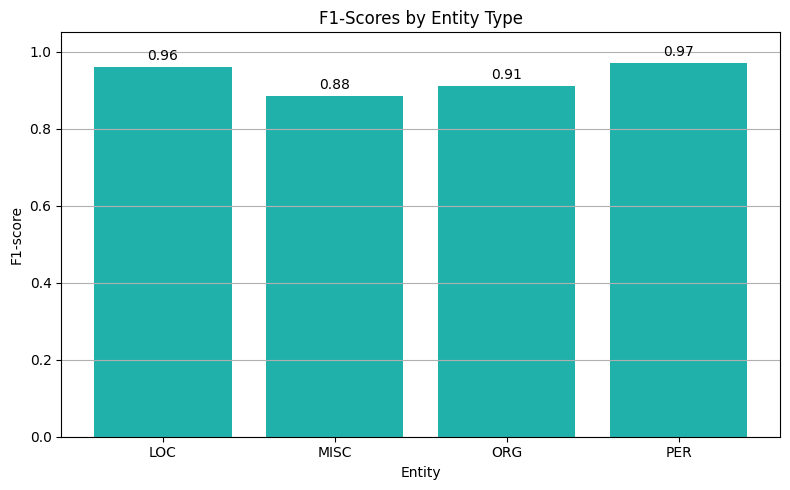

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

data = {
    "Entity": ["LOC", "MISC", "ORG", "PER"],
    "F1": [0.9598, 0.8844, 0.9104, 0.9696]
}

df = pd.DataFrame(data)

def plot_f1_from_summary(df, title="F1-Scores by Entity Type"):
    plt.figure(figsize=(8, 5))
    bars = plt.bar(df["Entity"], df["F1"], color="lightseagreen")

    plt.ylim(0, 1.05)
    plt.title(title)
    plt.ylabel("F1-score")
    plt.xlabel("Entity")
    plt.grid(axis="y")

    for bar in bars:
        height = bar.get_height()
        plt.annotate(f"{height:.2f}", xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

plot_f1_from_summary(df)


# Infer example

In [39]:
from transformers import pipeline

ner = pipeline(
    'token-classification',
    model = 'fine_tuned_model2',
    aggregation_strategy = 'simple' , 
    device = 0 
)

ner('Apple Inc. is planning to open a new store in San Francisco, California.')

[{'entity_group': 'ORG',
  'score': 0.99623376,
  'word': 'Apple Inc.',
  'start': 0,
  'end': 10},
 {'entity_group': 'LOC',
  'score': 0.9962647,
  'word': 'San Francisco',
  'start': 46,
  'end': 59},
 {'entity_group': 'LOC',
  'score': 0.9978264,
  'word': 'California',
  'start': 61,
  'end': 71}]

# Ukrainian

In [ ]:
!pip install seqeval

In [34]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaTokenizerFast, RobertaForTokenClassification
from torch.optim import AdamW
from sklearn.metrics import accuracy_score
from seqeval.metrics import classification_report
from collections import defaultdict
import os
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score


In [5]:
def read_iob_file(file_path):
    sentences = []
    sentence = []
    with open(file_path, encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line:
                if sentence:
                    sentences.append(sentence)
                    sentence = []
            else:
                token, label = line.split()
                sentence.append((token, label))
        if sentence:
            sentences.append(sentence)
    return sentences

In [6]:
class IOBNERDataset(Dataset):
    def __init__(self, sentences, tokenizer, label2id, max_len=128):
        self.sentences = sentences
        self.tokenizer = tokenizer
        self.label2id = label2id
        self.max_len = max_len

    def __len__(self):
        return len(self.sentences)

    def __getitem__(self, idx):
        words, labels = zip(*self.sentences[idx])
        encoding = self.tokenizer(list(words),
                                  is_split_into_words=True,
                                  truncation=True,
                                  padding='max_length',
                                  max_length=self.max_len,
                                  return_tensors="pt")

        word_ids = encoding.word_ids(batch_index=0)
        label_ids = []
        previous_word_idx = None
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(self.label2id[labels[word_idx]])
            else:
                label_ids.append(-100)
            previous_word_idx = word_idx

        return {
            "input_ids": encoding["input_ids"].squeeze(),
            "attention_mask": encoding["attention_mask"].squeeze(),
            "labels": torch.tensor(label_ids, dtype=torch.long)
        }

In [23]:
def train(model, loader, optimizer, device, id2label, history=None):
    model.train()
    total_loss = 0
    all_preds, all_labels = [], []
    step_losses = []

    progress_bar = tqdm(enumerate(loader), total=len(loader), desc="Training", leave=False)

    for step, batch in progress_bar:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
        loss, logits = outputs.loss, outputs.logits
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        step_losses.append(loss.item())

        if step % 100 == 0 and step != 0:
            avg_loss = total_loss / (step + 1)
            progress_bar.set_postfix(loss=avg_loss)

        preds = torch.argmax(logits, dim=-1)
        for i in range(labels.size(0)):
            true = [id2label[id.item()] for id, m in zip(labels[i], attention_mask[i]) if id != -100 and m == 1]
            pred = [id2label[p.item()] for p, l in zip(preds[i], labels[i]) if l != -100]
            all_labels.append(true)
            all_preds.append(pred)

    flat_true = [label for seq in all_labels for label in seq]
    flat_pred = [label for seq in all_preds for label in seq]
    f1 = f1_score(flat_true, flat_pred, average='macro')

    print(f"✅ Training Loss: {total_loss / len(loader):.4f}")
    print("📋 Training Classification Report:\n", classification_report(all_labels, all_preds))

    if history is not None:
        history["loss"].extend(step_losses)
        history["f1"].append(f1)


In [16]:
def evaluate(model, loader, device):
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            for i in range(labels.size(0)):
                true = [id2label[id.item()] for id, m in zip(labels[i], attention_mask[i]) if id != -100 and m == 1]
                pred = [id2label[p.item()] for p, l in zip(preds[i], labels[i]) if l != -100]
                all_labels.append(true)
                all_preds.append(pred)

    print("Validation Report:\n", classification_report(all_labels, all_preds))
    # return all_labels, all_preds


In [28]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_data = read_iob_file("/ner-uk-2-0/train.iob")
test_data = read_iob_file("/ner-uk-2-0/test.iob")

labels = sorted(set(l for sent in train_data + test_data for _, l in sent))
label2id = {l: i for i, l in enumerate(labels)}
id2label = {i: l for l, i in label2id.items()}

In [18]:
device

device(type='cuda')

In [29]:
model_name = "youscan/ukr-roberta-base"
tokenizer = RobertaTokenizerFast.from_pretrained(model_name, add_prefix_space=True)
model = RobertaForTokenClassification.from_pretrained(model_name, num_labels=len(label2id), id2label=id2label, label2id=label2id)
model.to(device)

Some weights of RobertaForTokenClassification were not initialized from the model checkpoint at youscan/ukr-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForTokenClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(52000, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (L

In [30]:
train_dataset = IOBNERDataset(train_data, tokenizer, label2id)
test_dataset = IOBNERDataset(test_data, tokenizer, label2id)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4)

In [31]:
optimizer = AdamW(model.parameters(), lr=3e-5)

In [35]:
for epoch in range(3):
    print(f"Epoch {epoch + 1}:")
    train(model, train_loader, optimizer, device, id2label)
    evaluate(model, test_loader, device)


Epoch 1:


✅ Training Loss: 0.0525
📋 Training Classification Report:
               precision    recall  f1-score   support

         ART       0.55      0.63      0.59       398
        DATE       0.84      0.87      0.86      1204
         DOC       0.15      0.23      0.18       101
         JOB       0.75      0.77      0.76      1304
         LOC       0.87      0.90      0.89      2123
        MISC       0.43      0.48      0.45       362
         MON       0.95      0.97      0.96       611
         ORG       0.86      0.91      0.88      3617
         PCT       0.92      0.91      0.91       169
      PERIOD       0.60      0.65      0.62       402
        PERS       0.95      0.97      0.96      3997
       QUANT       0.86      0.91      0.88       291
        TIME       0.55      0.25      0.34        24

   micro avg       0.84      0.88      0.86     14603
   macro avg       0.71      0.73      0.71     14603
weighted avg       0.85      0.88      0.86     14603

Validation Report:
 

✅ Training Loss: 0.0353
📋 Training Classification Report:
               precision    recall  f1-score   support

         ART       0.66      0.73      0.70       398
        DATE       0.88      0.91      0.90      1204
         DOC       0.19      0.32      0.24       101
         JOB       0.84      0.86      0.85      1304
         LOC       0.93      0.95      0.94      2123
        MISC       0.61      0.64      0.63       362
         MON       0.95      0.97      0.96       611
         ORG       0.91      0.94      0.92      3617
         PCT       0.91      0.94      0.93       169
      PERIOD       0.69      0.76      0.72       402
        PERS       0.98      0.98      0.98      3997
       QUANT       0.87      0.89      0.88       291
        TIME       0.55      0.46      0.50        24

   micro avg       0.89      0.92      0.91     14603
   macro avg       0.77      0.80      0.78     14603
weighted avg       0.90      0.92      0.91     14603

Validation Report:
 

✅ Training Loss: 0.0240
📋 Training Classification Report:
               precision    recall  f1-score   support

         ART       0.76      0.81      0.78       398
        DATE       0.91      0.93      0.92      1204
         DOC       0.34      0.53      0.41       101
         JOB       0.88      0.91      0.89      1304
         LOC       0.93      0.95      0.94      2123
        MISC       0.66      0.73      0.69       362
         MON       0.98      0.99      0.98       611
         ORG       0.94      0.96      0.95      3617
         PCT       0.95      0.97      0.96       169
      PERIOD       0.76      0.82      0.79       402
        PERS       0.97      0.98      0.98      3997
       QUANT       0.96      0.97      0.96       291
        TIME       0.74      0.71      0.72        24

   micro avg       0.92      0.94      0.93     14603
   macro avg       0.83      0.87      0.85     14603
weighted avg       0.92      0.94      0.93     14603

Validation Report:
 

In [41]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import torch

def evaluate(model, loader, device, label_list, id2label):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for batch in tqdm(loader, desc="Evaluating", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=-1)

            for i in range(labels.size(0)):
                true = [id2label[l.item()] for l, m in zip(labels[i], attention_mask[i]) if l != -100 and m == 1]
                pred = [id2label[p.item()] for p, l in zip(preds[i], labels[i]) if l != -100]
                all_labels.extend(true)
                all_preds.extend(pred)


    return all_labels, all_preds


def plot_confusion_matrix(true_labels, pred_labels, label_list):
    cm = confusion_matrix(true_labels, pred_labels, labels=label_list)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_list)

    fig, ax = plt.subplots(figsize=(12, 12))
    disp.plot(ax=ax, xticks_rotation=45, cmap='Blues', colorbar=False)
    plt.title("NER Confusion Matrix")
    plt.tight_layout()
    plt.show()



In [42]:
label_list = list(label2id.keys())
label_list


['B-ART',
 'B-DATE',
 'B-DOC',
 'B-JOB',
 'B-LOC',
 'B-MISC',
 'B-MON',
 'B-ORG',
 'B-PCT',
 'B-PERIOD',
 'B-PERS',
 'B-QUANT',
 'B-TIME',
 'I-ART',
 'I-DATE',
 'I-DOC',
 'I-JOB',
 'I-LOC',
 'I-MISC',
 'I-MON',
 'I-ORG',
 'I-PCT',
 'I-PERIOD',
 'I-PERS',
 'I-QUANT',
 'I-TIME',
 'O']

In [44]:
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import pandas as pd

report = classification_report(true_labels, pred_labels, output_dict=True)


In [49]:
from collections import defaultdict
import pandas as pd
import matplotlib.pyplot as plt

def combine_bi_labels(report):
    f1_scores = defaultdict(list)

    for label, metrics in report.items():
        if label in ["accuracy", "macro avg", "weighted avg", "micro avg"] or label == "O":
            continue
        base_label = label.split("-")[-1]
        f1_scores[base_label].append(metrics["f1-score"])

    combined_f1 = {k: sum(v)/len(v) for k, v in f1_scores.items()}
    return combined_f1

combined_f1 = combine_bi_labels(report)


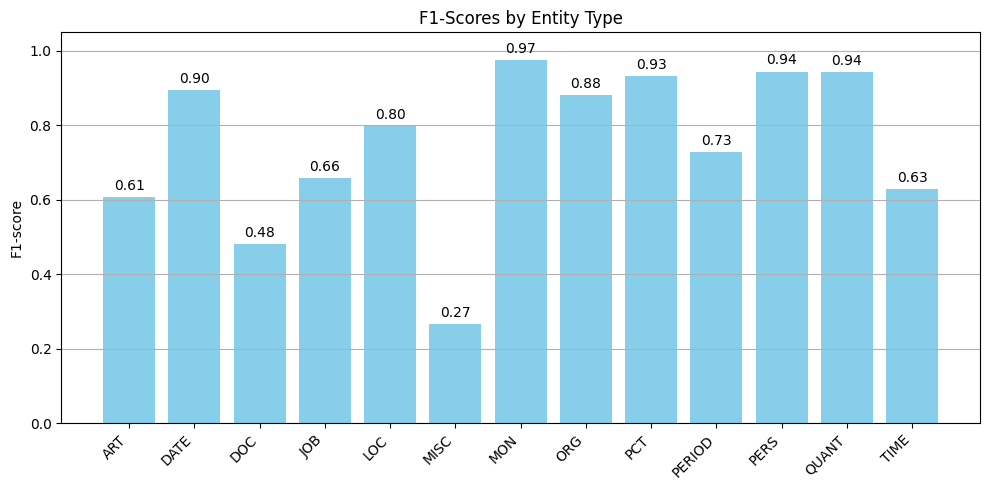

In [50]:
def plot_combined_f1_scores(f1_dict, title="F1-Scores by Entity Type"):
    labels = list(f1_dict.keys())
    scores = list(f1_dict.values())

    plt.figure(figsize=(10, 5))
    bars = plt.bar(labels, scores, color='skyblue')
    plt.title(title)
    plt.ylabel("F1-score")
    plt.ylim(0, 1.05)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y')
    
    for bar in bars:
        height = bar.get_height()
        plt.annotate(f"{height:.2f}", xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

plot_combined_f1_scores(combined_f1)


In [52]:
def ner_infer(sentence, model, tokenizer, id2label, device, max_len=128):
    model.eval()

    words = sentence.strip().split()
    encoding = tokenizer(words,
                         is_split_into_words=True,
                         return_offsets_mapping=True,
                         padding="max_length",
                         truncation=True,
                         max_length=max_len,
                         return_tensors="pt")

    input_ids = encoding["input_ids"].to(device)
    attention_mask = encoding["attention_mask"].to(device)
    word_ids = encoding.word_ids(batch_index=0)  # <-- FIXED HERE

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1)[0]

    previous_word_idx = None
    tokens_out = []
    labels_out = []

    for idx, word_idx in enumerate(word_ids):
        if word_idx is None or word_idx == previous_word_idx:
            continue
        label_id = predictions[idx].item()
        label = id2label[label_id]
        tokens_out.append(words[word_idx])
        labels_out.append(label)
        previous_word_idx = word_idx

    return list(zip(tokens_out, labels_out))


In [55]:
sentence = "Марія співає."

results = ner_infer(
    sentence,
    model=model,
    tokenizer=tokenizer,
    id2label=id2label,
    device=device
)

for token, label in results:
    print(f"{token:<15} {label}")


Марія           O
співає.         O


In [ ]:
repo_name = "ukr-ner-roberta-3ep"
from huggingface_hub import HfApi, HfFolder, Repository
model.push_to_hub(repo_name)
tokenizer.push_to_hub(repo_name)

In [62]:
model.save_pretrained("ner-ukr-roberta-3e-2")
tokenizer.save_pretrained("ner-ukr-roberta-3e-2")


('ner-ukr-roberta-3e-2/tokenizer_config.json',
 'ner-ukr-roberta-3e-2/special_tokens_map.json',
 'ner-ukr-roberta-3e-2/vocab.json',
 'ner-ukr-roberta-3e-2/merges.txt',
 'ner-ukr-roberta-3e-2/added_tokens.json',
 'ner-ukr-roberta-3e-2/tokenizer.json')

In [ ]:
from huggingface_hub import notebook_login
notebook_login()


In [ ]:
model_name = "ner-ukr-roberta-3e-2"

from transformers import RobertaForTokenClassification, RobertaTokenizerFast

model = RobertaForTokenClassification.from_pretrained("ner-ukr-roberta-3e-2")
tokenizer = RobertaTokenizerFast.from_pretrained("ner-ukr-roberta-3e-2")

model.push_to_hub(model_name)
tokenizer.push_to_hub(model_name)
